In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from cvxopt import matrix, solvers


In [2]:
df = pd.read_csv ('./selected_columns.csv')



df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430755 entries, 0 to 430754
Data columns (total 30 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   _MICHD    430755 non-null  int64  
 1   CHOLMED3  430755 non-null  int64  
 2   GENHLTH   430755 non-null  int64  
 3   MAXVO21_  430755 non-null  float64
 4   EMPLOY1   430755 non-null  int64  
 5   BPHIGH6   430755 non-null  int64  
 6   DIABETE4  430755 non-null  int64  
 7   CVDSTRK3  430755 non-null  int64  
 8   _AGE80    430755 non-null  int64  
 9   VETERAN3  430755 non-null  int64  
 10  CHCCOPD3  430755 non-null  int64  
 11  CHILDREN  430755 non-null  int64  
 12  _DRDXAR2  430755 non-null  int64  
 13  DEAF      430755 non-null  int64  
 14  DIFFWALK  430755 non-null  int64  
 15  TOLDHI3   430755 non-null  int64  
 16  PHYSHLTH  430755 non-null  int64  
 17  CHCKDNY2  430755 non-null  int64  
 18  FALL12MN  430755 non-null  int64  
 19  _RFCHOL3  430755 non-null  int64  
 20  TRNS

In [3]:
#Kiểm tra các giá trị của CVDINFR4
df['CVDINFR4'].value_counts()

CVDINFR4
0    407304
1     23451
Name: count, dtype: int64

In [4]:

class SVM:
    def __init__(self, C=1.0, class_weight=None, max_iter=1000):
        self.C = C
        self.class_weight = class_weight if class_weight else {0: 1.0, 1: 1.0}
        self.max_iter = max_iter
        
    def fit(self, X, y):
        y = y.astype(int)
        unique_classes = np.unique(y)
        assert set(unique_classes).issubset({0, 1}), "Chỉ hỗ trợ binary classification"
        assert all(c in self.class_weight for c in unique_classes), "Thiếu class weight"

        n_samples, n_features = X.shape
        y_ = np.where(y == 0, -1, 1)
        C_i = np.array([self.C * self.class_weight[c] for c in y])
        
        K = np.dot(X, X.T)
        P = matrix(np.outer(y_, y_) * K)
        q = matrix(-np.ones(n_samples))
        
        G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
        h = matrix(np.hstack((np.zeros(n_samples), C_i)))
        A = matrix(y_.reshape(1, -1).astype('double'))
        b = matrix(0.0)
        
        # Tắt thông báo
        solvers.options['show_progress'] = False
        solvers.options['maxiters'] = self.max_iter
        
        solution = solvers.qp(P, q, G, h, A, b)
        alphas = np.array(solution['x']).flatten()
        
        sv = alphas > 1e-5
        self.alphas = alphas[sv]
        self.sv_X = X[sv]
        self.sv_y = y_[sv]

        self.b = np.mean(
            self.sv_y - 
            np.sum(self.alphas * self.sv_y * self.sv_X.dot(self.sv_X.T), axis=1)
        )
        
    def predict(self, X):
        decision = np.sum(self.alphas * self.sv_y * X.dot(self.sv_X.T), axis=1) + self.b
        return np.where(decision >= 0, 1, 0)

In [5]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No CVD', 'CVD'], yticklabels=['No CVD', 'CVD'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()
# Hàm đánh giá
def evaluate_model(y_true, y_pred, model_name):
    print(f"Đánh giá cho {model_name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    plot_confusion_matrix(y_true, y_pred, model_name)


In [6]:

# Chuẩn bị dữ liệu
X = df.drop('CVDINFR4', axis=1)
y = df['CVDINFR4']
# Chia tập train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train_svm = X_train.sample(frac=0.05, random_state=42)  
y_train_svm = y_train.loc[X_train_svm.index]  # Lấy y tương ứng


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_svm)
X_test_scaled = scaler.transform(X_test)



Đánh giá cho SVM:
Accuracy: 0.9709
Precision: 0.6528
Recall: 1.0000
F1 Score: 0.7899


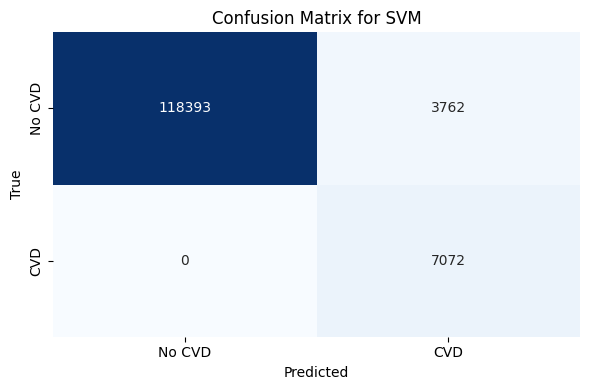

In [7]:
svm = SVM(
    C=31.418972875029368,
    class_weight={0: 1, 1: 18},
    max_iter=1000
)
svm.fit(X_train_scaled, y_train_svm.values)
y_pred_svm = svm.predict(X_test_scaled)
evaluate_model(y_test, y_pred_svm, "SVM")

In [8]:
joblib.dump(svm, '_svm.pkl')


['_svm.pkl']